In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
# import autokeras as ak
import corner
import os 
import sys
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [2]:
%%time
training_data = np.load("./nsi_data/sample_nsi_regression_1e7_v1.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

target = np.column_stack([training_data["theta23"], training_data["delta"]/180*np.pi ])
# target = target/180*np.pi 

x_train = data_all[:9000000]
y_train = target[:9000000]
y_train_delta = np.column_stack([np.sin(y_train[:,1]), np.cos(y_train[:,1])]) 
y_train_theta23 = y_train[:,0]

x_test = data_all[9000000:]
y_test = target[9000000:]
y_test_delta = np.column_stack([np.sin(y_test[:,1]), np.cos(y_test[:,1])]) 
y_test_theta23 = y_test[:,0]

CPU times: user 21 s, sys: 6.38 s, total: 27.4 s
Wall time: 27.4 s


In [3]:
path = './CVAE/DNN_{}'.format(8)
encoder1 = load_model(path + "/encoder_1_test_v2.h5", compile=False)
encoder2 = load_model(path + "/encoder_2_test_v2.h5", compile=False)
decoder = load_model(path + "/decoder_test_v2.h5", compile=False)

In [4]:
%%time
data_poisson_array = x_train[1:2]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, 10, 7))
log_var = tf.reshape(log_var, (-1, 10, 7))
weight = tf.reshape(weight, (-1, 10))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 1000000
prediction = []

Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, 7))
target_array = np.reshape([data_poisson_array for i in range(sample_amount)], (sample_amount, 144))
reconstruction_mean, reconstruction_var = decoder.predict([Z3, target_array])
temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                         loc=reconstruction_mean,
                         scale_diag= tf.sqrt(temp_var))
prediction = reconstruction_parameter.sample().numpy()

prediction = np.array(prediction)
logging.info(prediction.shape)

CPU times: user 49.7 s, sys: 6.91 s, total: 56.6 s
Wall time: 34.3 s


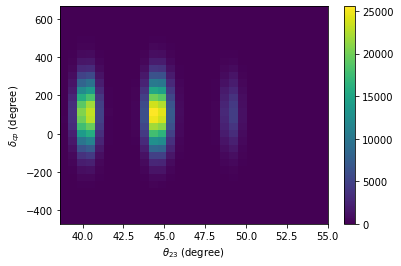

In [5]:
plt.hist2d(prediction[:,0], prediction[:,1]*180/np.pi, bins = 30)
plt.xlabel('$\\theta_{23}$ (degree)')
plt.ylabel('$\delta_{cp}$ (degree)')
plt.colorbar()
plt.savefig('tmp')
plt.show()

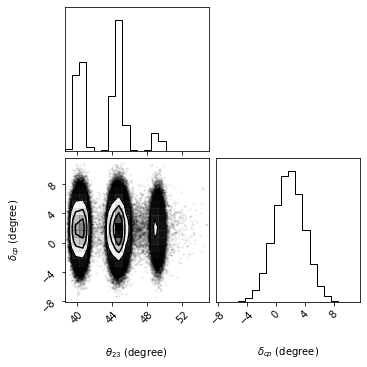

In [6]:
figure = corner.corner(prediction, labels=["$\\theta_{23}$ (degree)", "$\delta_{cp}$ (degree)"])

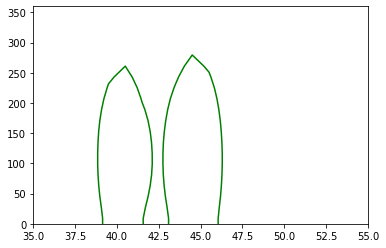

In [11]:
corner.hist2d(prediction[:,0], prediction[:,1]*180/np.pi,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
#                     range=[[44,54], [236, 336]],
                    range=[[35, 55], [0, 360]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
#                     bins = [bins_theta23_globes, bins_delta_globes],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )